In [1]:
# Adapted from
# https://github.com/salvadorgarciamunoz/kipet/blob/master/kipet/examples/Ex_12_multexp_conc_diffreact.py
#

In [2]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
from kipet.library.MultipleExperimentsEstimator import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd

In [3]:
builder = TemplateBuilder()  
    
builder.add_mixture_component('A',1.0)
builder.add_mixture_component('B',2.0)
builder.add_mixture_component('C',0.0)
builder.add_mixture_component('D',0.0)
    
builder.add_parameter('k1',init = 0.1, bounds = (0.0, 10.0))
builder.add_parameter('k2',init = 0.1, bounds = (0.0, 10.0))
    
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['B'] = -m.P['k1']*m.Z[t,'A']*m.Z[t,'B']-m.P['k2']*m.Z[t,'B']*m.Z[t,'C']
    exprs['C'] = m.P['k1']*m.Z[t,'A']*m.Z[t,'B']-m.P['k2']*m.Z[t,'B']*m.Z[t,'C']
    exprs['D'] = m.P['k2']*m.Z[t,'B']*m.Z[t,'C']
    return exprs

builder.set_odes_rule(rule_odes)

In [4]:
builder1 = TemplateBuilder()  
    
builder1.add_mixture_component('A',1.0)
builder1.add_mixture_component('B',1.0)
builder1.add_mixture_component('C',0.0)
builder1.add_mixture_component('D',0.0)
    
builder1.add_parameter('k1',init = 0.1, bounds = (0.0, 10.0))
builder1.add_parameter('k2',init = 0.1, bounds = (0.0, 10.0))

builder1.set_odes_rule(rule_odes)

In [5]:
C_frame1 = read_file('ABCD_cb0_2.csv', directory = '../my_data_sets')
C_frame2 = read_file('ABCD_cb0_1.csv', directory = '../my_data_sets')

read dir : /home/paperspace/learn_kipet/kipet_examples/../my_data_sets/ABCD_cb0_2.csv
read dir : /home/paperspace/learn_kipet/kipet_examples/../my_data_sets/ABCD_cb0_1.csv


In [6]:
C_frame1 = C_frame1[['A', 'C']]
C_frame2 = C_frame2[['B', 'D']]

In [7]:
start_time = {'Exp1':0.0, 'Exp2':0.0}
end_time = {'Exp1':4.0, 'Exp2':7.0}    
datasets = {'Exp1': C_frame1, 'Exp2': C_frame2}
sigmas = {'A':1, 'B':1, 'C':1, 'D':1}
variances = {'Exp1':sigmas, 'Exp2':sigmas}
builder_dict = {'Exp1':builder, 'Exp2':builder1}

In [8]:
options = dict()
options['linear_solver'] = 'ma27'

In [9]:
pest = MultipleExperimentsEstimator(datasets)
    
nfe = 50
ncp = 3

# Finally we run the parameter estimation. This solves each dataset separately first and then
# links the models and solves it simultaneously
results_pest = pest.run_parameter_estimation(solver = 'ipopt', 
                                                     tee=True,
                                                     nfe=nfe,
                                                     ncp=ncp,
                                                     covariance = False,
                                                     solver_opts = options,
                                                     start_time=start_time, 
                                                     end_time=end_time,
                                                     spectra_problem = False,
                                                     sigma_sq=variances,
                                                     builder = builder_dict)


SOLVING PARAMETER ESTIMATION FOR INDIVIDUAL DATASETS - For initialization

Solving for DATASET  Exp1
                 A         C
0.000000  1.003906  0.039959
0.311111  0.554819  0.328321
0.666667  0.375822  0.272322
0.977778  0.305279  0.244618
1.333333  0.269072  0.151982
1.644444  0.167628  0.219111
2.000000  0.150927  0.170158
2.311111  0.174195  0.167863
2.666667  0.111261  0.113357
2.977778  0.113912  0.171967
3.333333  0.088894  0.147807
3.644444  0.094967  0.160119
4.000000  0.025899  0.028531
Ipopt 3.12: linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of 

Overall NLP error.......:   2.5264466040054590e-09    2.5264466040054590e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.056
Total CPU secs in NLP function evaluations           =      0.008

EXIT: Optimal Solution Found.


In [10]:
print("The estimated parameters are:")

for k,v in results_pest.items():
    print(results_pest[k].P)

The estimated parameters are:
k1    1.072394
k2    1.849231
dtype: float64
k1    1.072394
k2    1.849231
dtype: float64


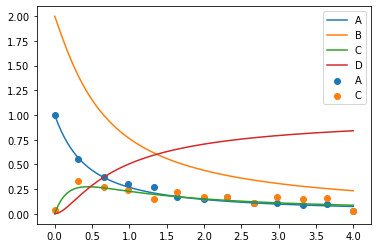

In [17]:
expt = 'Exp1'
fig, ax = plt.subplots()
for x in ['A', 'B', 'C', 'D']:
    if x in results_pest[expt].C.columns:
        ax.scatter(results_pest[expt].C.index, results_pest[expt].C[x], label = x)
    ax.plot(results_pest[expt].Z.index, results_pest[expt].Z[x], label = x)
ax.legend()

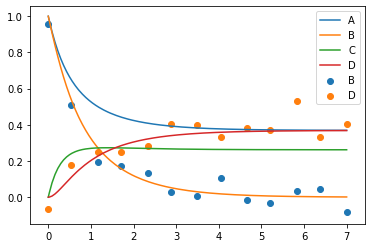

In [16]:
expt = 'Exp2'
fig, ax = plt.subplots()
for x in ['A', 'B', 'C', 'D']:
    if x in results_pest[expt].C.columns:
        ax.scatter(results_pest[expt].C.index, results_pest[expt].C[x], label = x)
    ax.plot(results_pest[expt].Z.index, results_pest[expt].Z[x], label = x)
ax.legend()